# CA4

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

### Reading data

In [2]:
df = pd.read_csv("./assets/train.csv", index_col = 0)

### Data exploration and visualisation

In [3]:
df.describe()

,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,80000.000000,80000.000000,79638.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000
mean,177.579220,24.132590,21.961115,20.507677,19.647426,19.085051,18.644640,4477.876713,301.0,3.511388,185.663050,5.783094e+18,0.577219,5136.309963,55587.191400,448.887437
std,96.409584,19.650113,35.581856,35.483302,1.855636,1.757630,35.462189,1961.579187,0.0,1.589033,148.433559,3.327780e+18,0.731597,2955.646539,1809.144282,272.328619
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995801e+17,-0.009971,266.000000,51608.000000,1.000000
25%,127.643892,5.170723,20.353990,18.963188,18.135523,17.732600,17.457503,3185.000000,301.0,2.000000,82.000000,2.841535e+18,0.055160,2523.750000,54233.000000,221.000000
50%,180.761747,23.603480,22.187965,21.101015,20.127550,19.405635,19.004420,4188.000000,301.0,4.000000,146.000000,5.606066e+18,0.425051,4979.000000,55868.000000,432.000000
75%,233.815698,39.904905,23.698457,22.125007,21.047242,20.401857,19.923013,5326.000000,301.0,5.000000,240.000000,8.331746e+18,0.704777,7400.000000,56777.000000,644.000000
max,359.999615,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


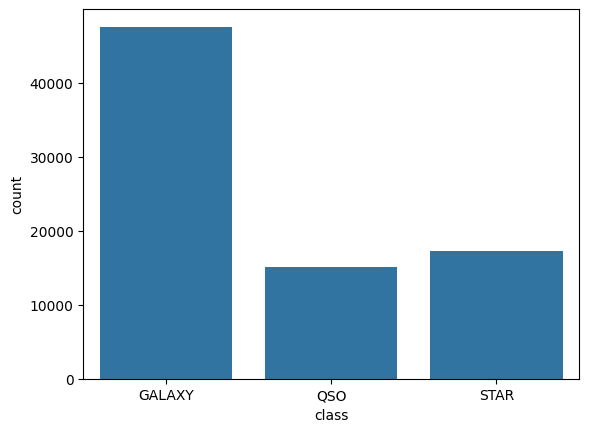

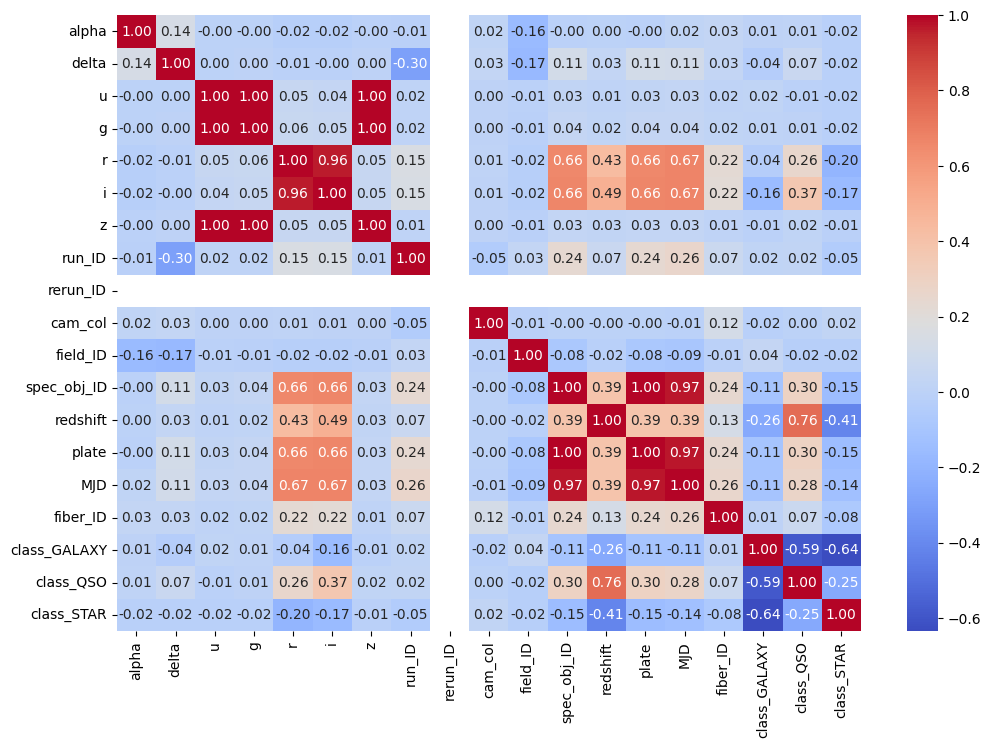

In [4]:
sns.countplot(x = df["class"])
plt.show()


# Doing classes to numbers so we can explore more, using onehotencoder since the class in nominal.
df_decoded = pd.get_dummies(df, columns = ["class"], dtype = int)

plt.figure(figsize=(12, 8))
sns.heatmap(df_decoded.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

In [5]:
# Checking dimensions
print(df.shape)


(80000, 17)


##### Conclusion
There is a noticeable imbalance in the dataset,  
with a significantly higher number of galaxy observations compared to other types of stellar objects.  
This imbalance may introduce bias in the analysis and should be taken into consideration.  
In addition, we are working with a huge dataset. We should therefore use Stratified K-Fold as a Cross Validation  
  
Such uneven distribution can also influence the choice of models.  
like Logistic Regression, Decision Trees,  
and Support Vector Classifiers (SVC) may have difficulty performing well under these conditions.  
We will still try out SVC.  

The heatmap indicates complex correlations among several features.  
There is a perfect positive correlation between the variables:  
u and z, g and z, and g and u.  
A strong positive correlation is also observed between i and r.  
In addition, strong positive relationships are found between MJD and spec_obj_ID, and between MJD and plate.  
Spec_obj_ID and plate show a perfect positive correlation as well.  
Lastly, there is a strong negative correlation among the different target classes.


### Data cleaning

In [6]:
print("missing values: \n", df.isnull().sum())
print("\nduplicates: \n", df[df.duplicated()].sum())


missing values: 
 alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64

duplicates: 
 alpha          0.0
delta          0.0
u              0.0
g              0.0
r              0.0
i              0.0
z              0.0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID    0.0
class            0
redshift       0.0
plate            0
MJD              0
fiber_ID         0
dtype: object


In [7]:
# Dropping missing values
df = df.dropna()

print(f"Shape: {df.shape}")

Shape: (79638, 17)


In [8]:
# We want to see the visualize the complex patterns
"""sns.pairplot(df)
plt.show()"""

'sns.pairplot(df)\nplt.show()'

In [9]:
# Test-train
X = df.drop(columns = ["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 1)

### Data preprocessing and visualisation

In [10]:
# Creating Pipelines, 
RFC = Pipeline([
    ('pca', PCA(n_components = 0.95)),
    ('lda', LDA()),
    ('clf', RandomForestClassifier(random_state = 42))
])

SVM = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 0.95)),
    ('lda', LDA()),
    ('svc', SVC())
])

### Modelling

In [12]:
# Grid Search with cross-validation, StritifiedKFold because of the large dataset and the imbalance
def grid_search(pipeline, param_grid):
    gs = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = 'f1_macro', cv = StratifiedKFold(n_splits = 5))
    gs.fit(X_train, y_train)
    print("CV: DONE")
    
    score = 1
    return gs, score
    

In [ ]:
# SVC, parts of the code is taken from Chapter_6_part_2a.ipynb from Canvas
param_range  = [0.1, 1.0, 10.0]         # For regularization parameter C.
param_range2 = [0.01, 0.1, 1.0]         # For scaling parameter gamma og rbf-kernel.

param_grid = [{'svc__C': param_range, 'svc__gamma': param_range2}]

gs, cvs = grid_search(SVM, param_grid)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(cvs), np.std(cvs)))

### Final evaluation

### Kaggle submission